#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
To: /home/jupyter/week 5/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 214MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


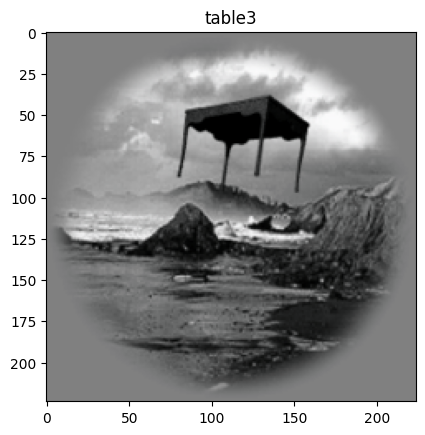

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

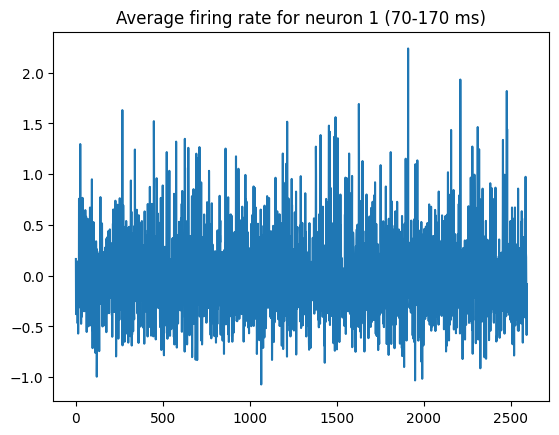

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 19/04/23 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

## 0: Packtage and setup

In [7]:
#import packtage

import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from math import *
from sklearn import metrics as ms
from sklearn.decomposition import PCA, IncrementalPCA

In [8]:
from sklearn import linear_model
from scipy.stats import pearsonr

In [9]:
model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
model.AuxLogits = None

In [10]:
#model

In [11]:
#do the batch
dataloader_train = DataLoader(torch.Tensor(stimulus_train), batch_size = 32)
dataloader_valid = DataLoader(torch.Tensor(stimulus_val), batch_size = 32)
dataloader_test = DataLoader(torch.Tensor(stimulus_test), batch_size = 32)

In [12]:
#choose of layr (according to the result in part challenge)

Name = ['Mixed_6a','Mixed_6b','Mixed_6c','Mixed_6d','Mixed_6e']

model_layer = {'Mixed_6a':model.Mixed_6a,'Mixed_6b':model.Mixed_6b,'Mixed_6c':model.Mixed_6c,'Mixed_6d':model.Mixed_6d,'Mixed_6e':model.Mixed_6e}

correlation = {'Mixed_6a':[],'Mixed_6b':[],'Mixed_6c':[],'Mixed_6d':[],'Mixed_6e':[]}
variance = {'Mixed_6a':[],'Mixed_6b':[],'Mixed_6c':[],'Mixed_6d':[],'Mixed_6e':[]}
mCorr = {'Mixed_6a':[],'Mixed_6b':[],'Mixed_6c':[],'Mixed_6d':[],'Mixed_6e':[]}
mVar = {'Mixed_6a':[],'Mixed_6b':[],'Mixed_6c':[],'Mixed_6d':[],'Mixed_6e':[]}

In [13]:
stimulus_train.shape

(2592, 3, 224, 224)

In [14]:
stimulus_val.shape

(288, 3, 224, 224)

## 1 : function to apply the model

In [15]:
features = []
#function to hook the features
def get_features():
    def hook(model, input, output):
        features.append(output.detach())
    return hook

In [16]:
#function that get the PCs from a layer (with the training set)
def get_layer(name) :
    hooked =model_layer[name].register_forward_hook(get_features())
    
    for batch in dataloader_train:
        pred_res = model(torch.Tensor(batch))
    
    hooked.remove()
    
    output = torch.concat(features,axis=0).detach().numpy()
    pca.fit(output.reshape(output.shape[0],-1))
    
    return pca.transform(output.reshape(output.shape[0],-1))

In [17]:
#fonction that get the PCs from a layer (with the validation dataset)
def get_validation(name) :
    hooked =model_layer[name].register_forward_hook(get_features())
    
    for batch in dataloader_valid:
        pred_res = model(torch.Tensor(batch))
    
    hooked.remove()

    output = torch.concat(features,axis=0).detach().numpy()
    
    return pca.transform(output.reshape(output.shape[0],-1))

In [18]:
#fonction that get the PCs from a layer (with the validation dataset)
def get_test(name) :
    hooked =model_layer[name].register_forward_hook(get_features())
    
    for batch in dataloader_test:
        pred_res = model(torch.Tensor(batch))
    
    hooked.remove()

    output = torch.concat(features,axis=0).detach().numpy()
    
    return pca.transform(output.reshape(output.shape[0],-1))

## 2 : function for model evaluation

In [19]:
#value is the expected neural activity and prediction is the predicted one
#this function plot some neural activities and compute the correlation and explained variance 
#display the mean of correlation and explained variance and return two array

def evaluation(value, prediction, title) :
    
    #plot neural activities
    plt.figure()
    
    N = 5
    fig, axs = plt.subplots(N, 1)

    for n in range(N) : 
        axs[n].plot(value[:,n])
        axs[n].plot(prediction[:,n])

    plt.show()
    plt.savefig('figure/bunch of prediction vs recording neural activity '+ title)

    #compute correlation and explained variance
    correlation = []
    var = []

    for i in range(value.shape[1]) : #each neuron
        correlation.append(pearsonr(value[:,i],prediction[:,i])[0])
        var.append(ms.explained_variance_score(value[:,i],prediction[:,i]))
    
    #plot correlation and explained variance
    plt.figure()
    plt.title('explained variance for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("explained variance")
    plt.plot(var)
    plt.savefig('figure/explained variance for each neuron '+ title)
    plt.show()
    
    plt.figure()
    plt.title('correlation for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("correlation")
    plt.plot(correlation)
    plt.savefig('figure/correlation for each neuron '+ title)
    plt.show()
    
    mCorr =np.mean(correlation)
    mVar =np.mean(var)
    #print the means
    print('mean of correlation ', mCorr)
    print('mean of explained variance ',mVar)
    
    #return arrays
    return correlation,var,mCorr,mVar

## 3 : model of part 1

In [20]:
LinearModel = linear_model.Ridge()
#we chose the normal model with redge because the optimal value was too high for alpha. This model will have alpha = 10

## 4 : Predict neural activity layer by layer

On layer Mixed_6a
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

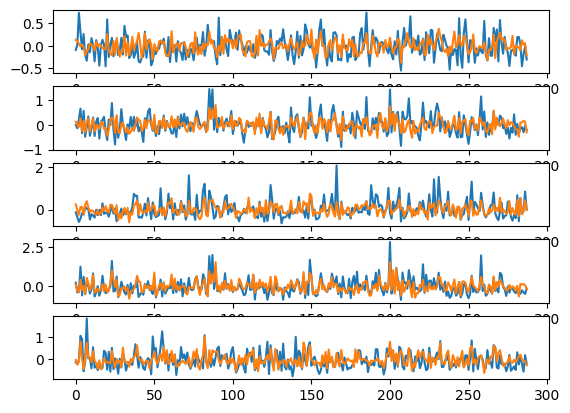

<Figure size 640x480 with 0 Axes>

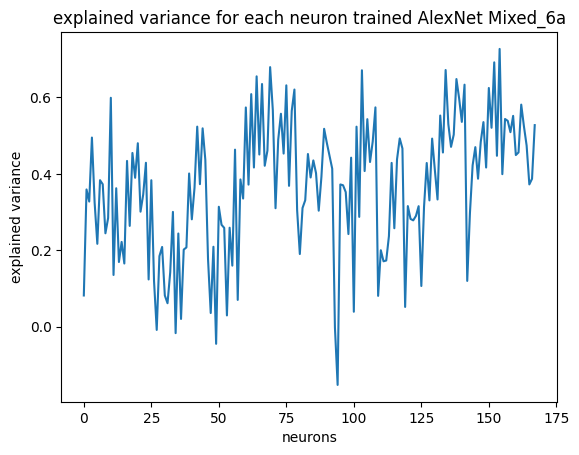

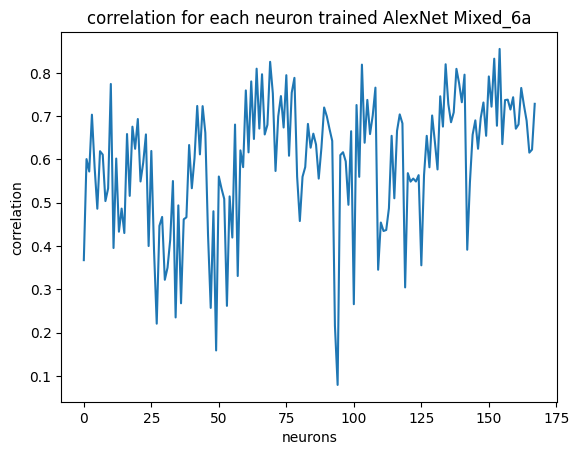

mean of correlation  0.5954126581243182
mean of explained variance  0.366865031066395
On layer Mixed_6b
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

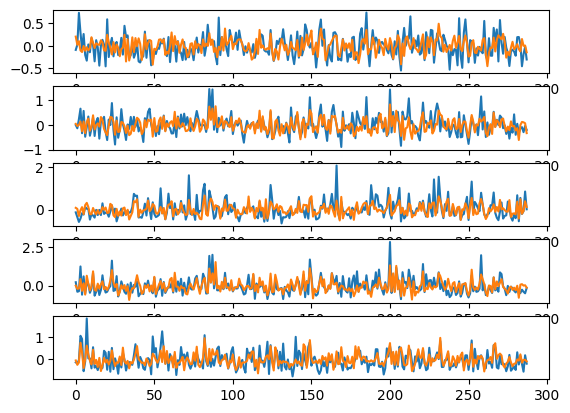

<Figure size 640x480 with 0 Axes>

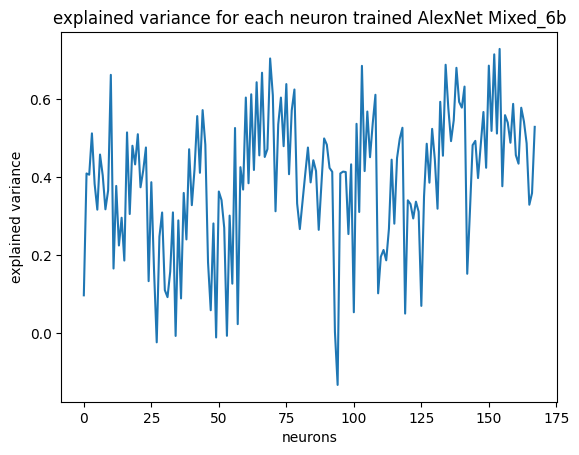

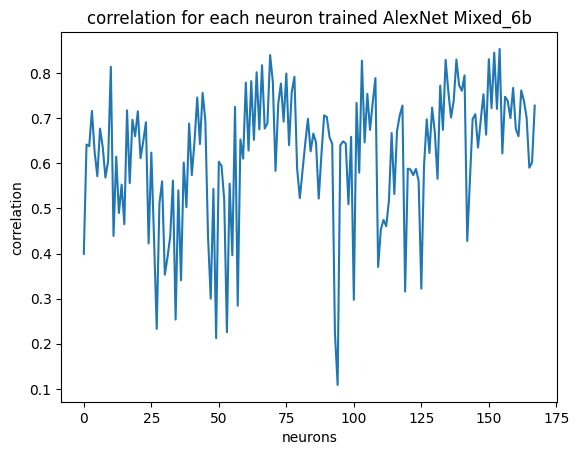

mean of correlation  0.6183097760681987
mean of explained variance  0.3931192471867516
On layer Mixed_6c
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

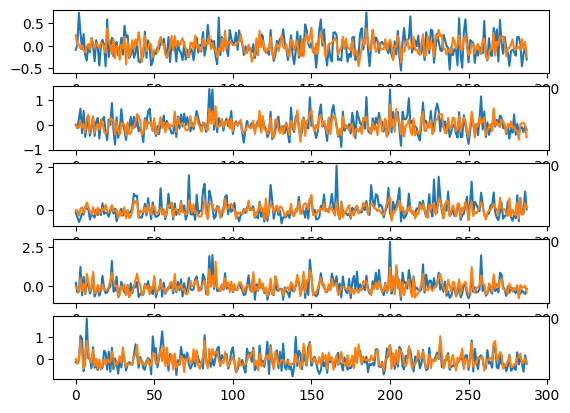

<Figure size 640x480 with 0 Axes>

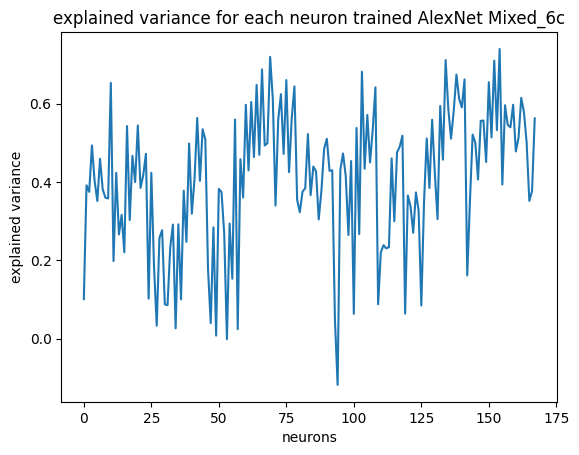

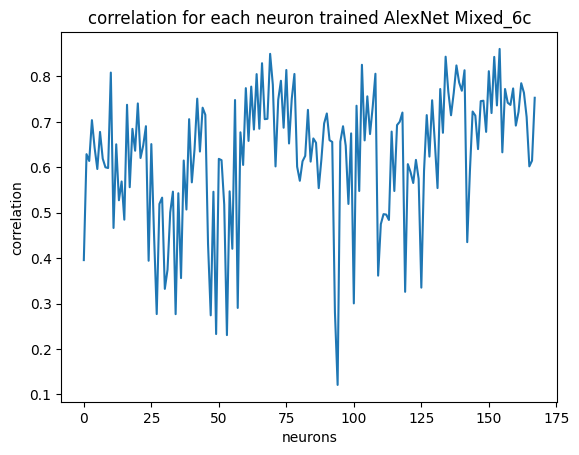

mean of correlation  0.6273342742311886
mean of explained variance  0.40569802692958284
On layer Mixed_6d
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

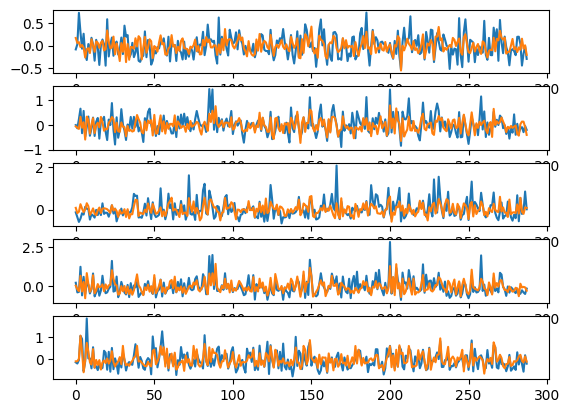

<Figure size 640x480 with 0 Axes>

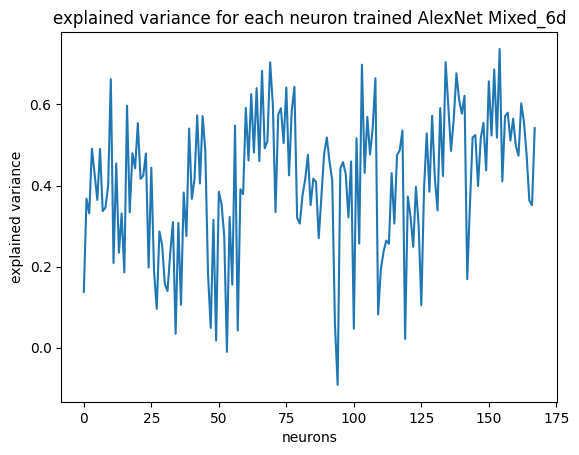

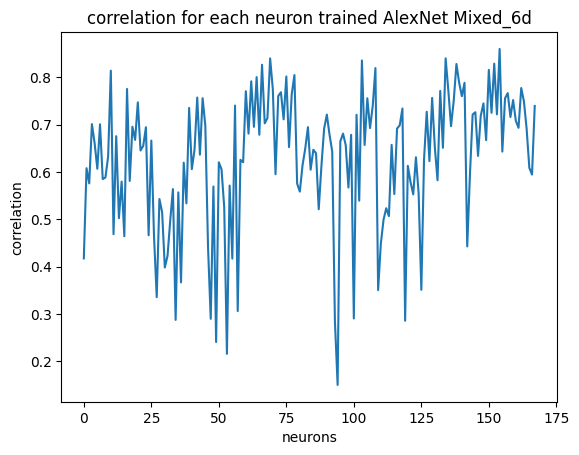

mean of correlation  0.6301202594251697
mean of explained variance  0.40895730682781767
On layer Mixed_6e


In [ ]:
#layer by layer :
#take activation on training dataset
#compute PCs and fit the pca
#take activation on validation dataset
#apply PCA
#fit the linearModel and predict
#evaluate the model

for layer in Name :
    print("On layer "+layer)
    
    pca = PCA(n_components=1000)
    features = []
    PC_activation = get_layer(layer)
    print("Done 1000 PCs for each layer activation")
    
    features = []
    PC_activation_validation = get_validation(layer)
    print("Done 1000 PCs for prediction")
    
    LinearModel.fit(PC_activation,spikes_train)
    y_pred = LinearModel.predict(PC_activation_validation)
    correlation[layer],variance[layer],mCorr[layer],mVar[layer] = evaluation(spikes_val, y_pred, "trained AlexNet "+layer)

## 5 : Plot correlation and explained variance regarding the layer

In [ ]:
plt.figure()
plt.bar(mCorr.keys(), mCorr.values())
plt.title("distribution of correlation with respect to the layer of the network")
plt.show()
plt.savefig('figure/correlation_untrain')

plt.figure()
plt.bar(mVar.keys(), mVar.values())
plt.title("distribution of explained variance with respect to the layer of the network")
plt.show()
plt.savefig('figure/variance_untrain')

In [ ]:
mVar

In [ ]:
mCorr

## 6 : Do on the test dataset 

We just gonna apply the model on the test set, we could us both the activation from the train and validation dataset to fit the PCA and test on the test dataset

In [ ]:
layer = 'Mixed_6d'

print("On layer "+layer)
features = []
PC_activation_test = get_test(layer)
print("Done 1000 PCs for test prediction")
    
y_pred = LinearModel.predict(PC_activation_test)

In [ ]:
#y_pred #result